In [2]:
import numpy as np
np.random.seed(0)
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

Firstly we have read the audio data using wavfile imported from spicy.io module

In [ ]:
sampling_rate, mix1 = wavfile.read('mix1.wav')
sampling_rate, mix2 = wavfile.read('mix2.wav')
sampling_rate, source1 = wavfile.read('source1.wav')
sampling_rate, source2 = wavfile.read('source2.wav')

We use g and g_der for determining the new value for w.

In [ ]:
def g(x):
    return np.tanh(x)

In [ ]:
def g_der(x):
    return 1 - g(x) * g(x)

Next we have created a function center that signals by subtracting the mean.

In [ ]:
def center(x):
    x = np.array(x)
    
    mean = x.mean(axis=1, keepdims=True)
    
    return x - mean

We are using a function whiten before we apply the ICA algorithm. This function helps to transform in such a way that potential correlations between the components are removed and the variance of each component is equal to 1. Another way of looking at it is that the covariance matrix of the whitened signal will be equal to identity matrix.

In [ ]:
def whitening(x):
    cov = np.cov(x)

    d, E = np.linalg.eigh(cov)

    D = np.diag(d)

    D_inv = np.sqrt(np.linalg.inv(D))

    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))

    return x_whiten

Defining the function calculate_new_w this function updates the de-mixing matrix w.

In [ ]:
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T, X)).mean() * w

    w_new /= np.sqrt((w_new ** 2).sum())

    return w_new

Here we are defining the main method which calls the preprocessing functions, initializes w to some random set of values and continuously update the value of w. Again, convergence can be judged by the fact that an ideal w would be orthogonal, and hence w multiplied by its transpose would be approximately equal to 1. After computing the optimal value of w for each component, we take the dot product of the resulting matrix and the signal x to get the sources.

In [ ]:
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    
    X = whitening(X)
        
    components_nr = X.shape[0]

    W = np.zeros((components_nr, components_nr), dtype=X.dtype)

    for i in range(components_nr):
        
        w = np.random.rand(components_nr)
        
        for j in range(iterations):
            
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
            
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            
            w = w_new
            
            if distance < tolerance:
                break
                
        W[i, :] = w
        
    S = np.dot(W, X)
    
    return S

We define a function to plot and compare the original, mixed and predicted signals.

In [ ]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

we create a method to artificially mix different source signals in the mix_sources function.

In [ ]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        
        max_val = np.max(mixtures[i])
        
        if max_val > 1 or np.min(mixtures[i]) < 1:
            
            mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]
    
    if apply_noise:
        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

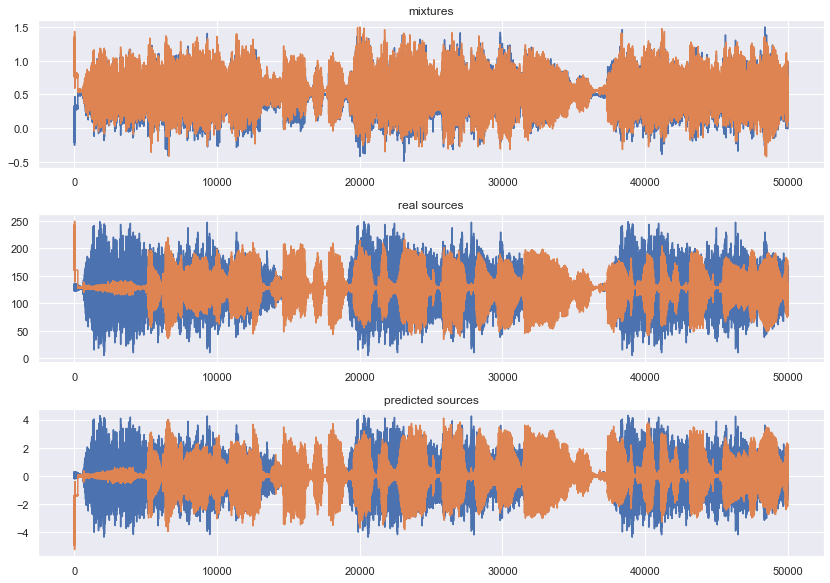

In [ ]:
actual = mix_sources([source1, source2], False)
X = mix_sources([mix1, mix2])
S = ica(X, iterations=1000)

plot_mixture_sources_predictions(X, [source1, source2], S)

wavfile.write('out1.wav', sampling_rate, S[0])
wavfile.write('out2.wav', sampling_rate, S[1])

Plotting the graph using the scikit-learn implementation wherein we successfully speared the mixed audio. 

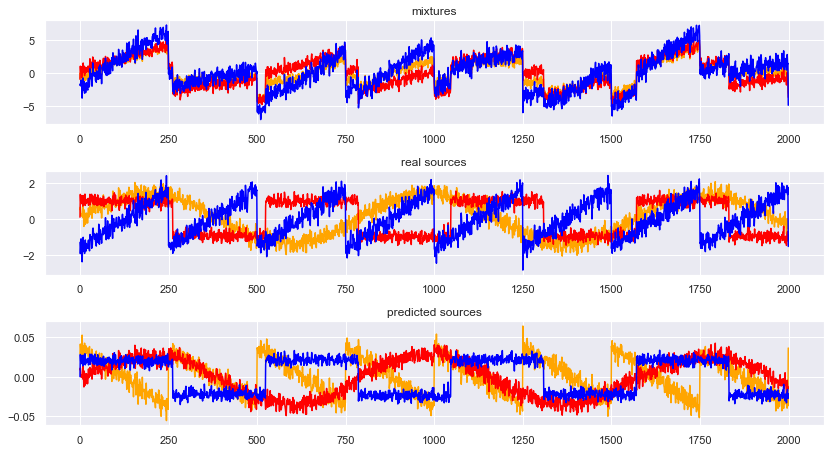

In [ ]:
from sklearn.decomposition import FastICA

np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = np.dot(S, A.T)

ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)

fig = plt.figure()

models = [X, S, S_]

names = ['mixtures', 'real sources', 'predicted sources']

colors = ['orange', 'red', 'blue']

for i, (name, model) in enumerate(zip(names, models)):
    plt.subplot(4, 1, i+1)
    plt.title(name)
    for sig, color in zip (model.T, colors):
        plt.plot(sig, color=color)
        
fig.tight_layout()        
plt.show()